# Final Project Math104 C

## The cellar

### a)


Let $L$ be an arbitrary depth, and let's consider a space discretization $x_0<...<x_M$ with $x_0=0$ and $x_{i+1}=x_i + \Delta x$ for all $i \geq 0$,
where $\Delta x = \frac{L}{M}$. We can then replace $\frac{\partial ^2 u}{\partial x^2}$ using a three-point finite difference approximation :
$$ \frac{\partial ^2 u}{\partial x^2} (x_i,t) \approx \frac{u(x_{i+1},t) + u(x_{i-1},t) - 2u(x_i,t)}{\Delta x^2} $$
Using Taylor's approximation, we find its truncation error to be $O((\Delta x)^2)$

If we now consider $L$ to be large enough, we can write $u(L,t) \approx u(\infty, t) = 0$ (this is not very mathematical but writing it properly in Markdown would be a pain).

To avoid cumbersome notation, let $u_i(t) = u(x_i, t)$ for all i. We thus get an N-1 dimensional ODE initial value problem :
$$ \frac{du_i(t)}{dt} = \kappa \frac{u_{i+1}(t) + u_{i-1}(t) - 2u_i(t)}{\Delta x^2}$$

Which we solve through a backward difference scheme for a time discretization $t_0<...<t_N$ with arbitrary non-zero $t_0$ and $t_{j+1} = t_{j} + \Delta t$ where $\Delta t = \frac{Y}{N}$ :

$$ \frac{u_i(t_{j+1})-u_i(t_j)}{\Delta t} = \kappa \frac{u_{i+1}(t_j) + u_{i-1}(t_j) - 2u_i(t_j)}{\Delta x^2}\space (1)$$

Once again, through Taylor's approximation, we find the left side of this last equation to be $O(\Delta t)$.

Hence this scheme's local truncation error is $O(\Delta t + (\Delta x)^2)$. Thus ***the scheme is of time order 1 and spatial order 2***, from which it follows that ***the scheme is consistent*** (according to definition 13.5 of the lecture notes).

Once again, to avoid cumbersome notation, let $u_i^j=u_i(t_j)$, and $\alpha = \frac{\Delta t}{(\Delta x)^2}$. Suppose now we know for a certain m all $u_m^n$, and we wish to compute all $u_m^{n+1}$.

We can thus rewrite the ODE problem described by (1) as :
$$ \begin{bmatrix}
1+2\alpha & - \alpha & 0 & - & 0 \\
- \alpha & 1+2\alpha & - \alpha &  & 0 \\
0 & - \alpha & ... &  &  \\
| &  &  & ... & - \alpha \\
0 & 0 & e_3 & - \alpha & 1+2\alpha 
\end{bmatrix}  \begin{bmatrix} u_1^{n+1} \\ : \\ . \\ \\ u_{M-1}^{n+1}  \end{bmatrix} = \begin{bmatrix}
u_1^{n} \\
: \\
. \\
 \\
u_{M-1}^{n} 
\end{bmatrix} + \begin{bmatrix}
\alpha u_0^{n+1} \\
: \\
. \\
 \\
\alpha u_{M}^{n+1} 
\end{bmatrix} \space (2)$$

Solving the scheme is thus equivalent at each time step to solving a linear system :
$ AU^{m+1} = b^m $ where A is the tridiagonal matrix, $U^{m+1}$ the vector with the unknown $u_m^{n+1}$, and $b^m$ is the known right side of (2). We thus are able to find $u_m^{n+1}$ as a function of the $u_m^n$.

We furthermore notice that for all values of $ \alpha >0$, the norm of A is lesser than 1, which allows us to conclude that ***the scheme is unconditionally stable***.



### b)

In [24]:
import math
import numpy as np
from scipy import sparse
from scipy.fftpack import *
from scipy.sparse import diags
import matplotlib.pyplot as plt

In [32]:
def Backwards(M, T = 3.15*(10**7), L = 10000, k =2*(10**(-3)), q = 0.0071):
    # M = GRID POINTS on space interval
    N = (M**2) #GRID POINTS on time interval

    x0, xL = 0, L 

    dx = (xL - x0)/(M-1)

    t0, tF = 1, T+1 

    dt = (tF - t0)/(N-1)

    alpha = k*dt/(dx**2)

    xspan = np.linspace(x0, xL, M)
    tspan = np.linspace(t0, tF, N)

    main_diag = (1 + 2*alpha)*np.ones((1,M))
    off_diag = -alpha*np.ones((1, M-1))
    a = main_diag.shape[1]
    diagonals = [main_diag, off_diag, off_diag]

    A = sparse.diags(diagonals, [0,-1,1], shape=(a,a)).toarray()
    A[0,1] = -2*alpha
    A[M-1,M-2] = -2*alpha

    # --- Initialize U -----
    U = np.zeros((M, N))

    # ---- Boundary conditions -----
    f = np.arange(1, N+1) #LeftBC
    f = U[0,:] = np.sin(2.0*(np.pi/T)*tspan)
    
    g = np.arange(1, N+1) #RightBC
    g = U[-1,:] = np.zeros(N)
    
    # --- Initial condition -----
    U[:,0] = np.sin(2.0*(np.pi/T)*t0) * np.exp((-q) * xspan)

    for i in range(1, N):
        c = np.zeros((M-2,1)).ravel()
        b1 = np.asarray([2*alpha*dx*f[i], 2*alpha*dx*g[i]])
        b1 = np.insert(b1, 1, c)
        b2 = np.array(U[0:M, i-1])
        b = b1 + b2  # Right hand side
        U[0:M, i] = np.linalg.solve(A,b)  # Solve x=A\b
   
    return (U, tspan, xspan)

U, tspan, xspan = Backwards(M = 11)

In [26]:
#These are the depths we computed the solution on
depth = xspan/100
depth

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [27]:
months = tspan/2.628e+6 #time in months rather than seconds
idx = [x+1 for x in range(0, 120 ,10)]

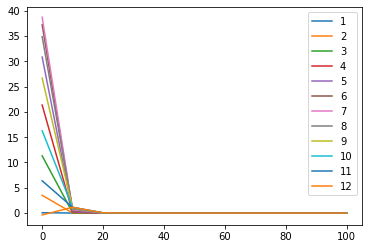

In [28]:
for i in idx:
    plt.plot(depth, U[:,i], )
    plt.legend([m for m in range(1,13)]) # the numbers represent the months of the year

### c)

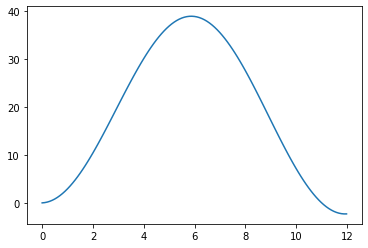

In [29]:
plt.plot(months, U[0,:]) #temperature at the surface

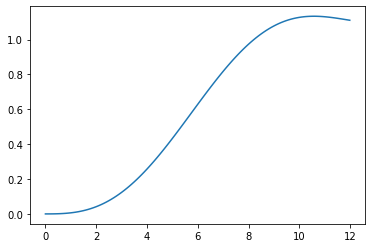

In [30]:
plt.plot(months, U[1,:]) #temperature at depth[1]

In [31]:
print('Thus the depth at which the temperature is opposite in phase to the ground is '+str(round(depth[1]))+'m')

Thus the depth at which the temperature is opposite in phase to the ground is 10m
